# MLFlow 2 

In [ ]:
# Importation de librairies standards:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

# un nouvel import utile pour la 3D:
from matplotlib import cm
import seaborn as sns
sns.set_style("whitegrid")

# Les instructions suivantes sont TRES utiles pour recharger automatiquement 
# le code modifié dans les librairies externes
%load_ext autoreload
%autoreload 2

# Pour mesurer le temps
import time
import random
import graphviz as gv


# Importation de votre librairie iads:
# La ligne suivante permet de préciser le chemin d'accès à la librairie iads
import sys
sys.path.append('../')   # iads doit être dans le répertoire père du répertoire courant !

# Importation de la librairie iads
import iads as iads

# importation de Classifiers
from iads import Classifiers as classif

# importation de utils
from iads import utils as ut

# importation de evaluation
from iads import evaluation as ev

# importation de Clustering
from iads import Clustering as clust

# commande TRES utile pour recharger automatiquement le code que vous modifiez dans les modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Import MLFlow
import mlflow
mlflow.end_run()
import mlflow.pyfunc
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve
)


In [ ]:
# Prepare data
# Charger les données
file_path = "../../data/Loan_Data_Preprocessed.csv"
df = pd.read_csv(file_path)

#  Séparer les features et la cible
X = df.drop(columns=['customer_id', 'default'])  # Exclure l'ID client et la cible
y = df['default']

# Définition de variables
X_noms = X.columns

# Conversion en np.ndarray
X = np.array(X)
y = np.array(y)

# Définition de variables
dim = len(X[0])
nb_labels = len(np.unique(y))

# -----
# Définition des données d'apprentissage (on reprend les données data_gauss générées plus haut)
np.random.seed(42)
(train_desc, train_label), (test_desc, test_label) = ut.genere_train_test(X, y,100)

data_train = train_desc
label_train = train_label
data_test = test_desc
label_test = test_label


index = random.sample(range(len(X)),7000)
data_cv, label_cv = X[index], y[index]

## Perceptron

In [8]:
# Configure param grid
param_grid = {
    'learning_rate': [0.01, 0.001, 0.005],
    'init': [True, False],
}

# Initialisation du modèle Perceptron
perceptron = classif.ClassifierPerceptron(dim)
# GridSearchCV pour optimiser les hyperparamètres
grid_search = GridSearchCV(estimator=perceptron, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(data_train, label_train)

# Affichage des meilleurs paramètres
print("Meilleurs hyperparamètres : ", grid_search.best_params_)

# Utiliser le meilleur modèle pour prédire
best_rf = grid_search.best_estimator_
y_pred = np.array(
    [best_rf.predict(data_test[i]) for i in range(len(data_test))]
)

# Calcul des métriques avec le meilleur modèle
accuracy = accuracy_score(test_label, y_pred)
report = classification_report(test_label, y_pred)

# Log des résultats
mlflow.log_param("best_params", grid_search.best_params_)
mlflow.log_metric("accuracy", accuracy)
mlflow.log_text(report, "classification_report_optimized.txt")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ......................init=True, learning_rate=0.01; total time=   0.0s
[CV] END ......................init=True, learning_rate=0.01; total time=   0.0s
[CV] END ......................init=True, learning_rate=0.01; total time=   0.0s
[CV] END ......................init=True, learning_rate=0.01; total time=   0.0s
[CV] END .....................init=True, learning_rate=0.001; total time=   0.1s
[CV] END ......................init=True, learning_rate=0.01; total time=   0.1s
[CV] END .....................init=True, learning_rate=0.001; total time=   0.1s
[CV] END .....................init=True, learning_rate=0.001; total time=   0.1s
[CV] END .....................init=True, learning_rate=0.001; total time=   0.1s
[CV] END .....................init=True, learning_rate=0.001; total time=   0.1s
[CV] END .....................init=True, learning_rate=0.005; total time=   0.0s
[CV] END .....................init=True, learning

/Users/hoangthuyduongvu/miniconda3/envs/banking-mlops/lib/python3.13/site-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan]
  warnings.warn(


In [ ]:
# Creat perceptron on best params
best_rf = classif.ClassifierPerceptron(dim, learning_rate=grid_search.best_params_['learning_rate'], init=grid_search.best_params_['init'])

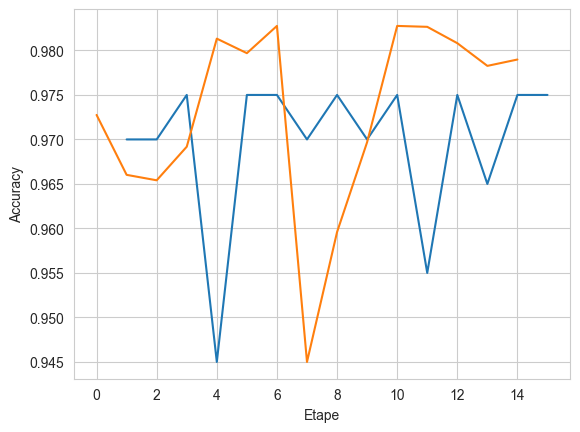

Accuracy finale (train):  0.975
Accuracy finale (test) :  0.9789795918367347


<Figure size 640x480 with 0 Axes>

In [9]:
# -----
# Apprentissage pas à pas du perceptron et mémorisation de l'accuracy à chaque étape:
# Listes qui vont servir à mémoriser les accuracy du perceptron à chaque étape:
train_acc = []
test_acc = []

# Réalisation de N itérations
N = 15
for i in range(N) : 
    L_train = best_rf.train(data_train, label_train)
    train_acc.append(best_rf.accuracy(data_train, label_train))
    
    L_test = best_rf.train(data_test, label_test)
    test_acc.append(best_rf.accuracy(data_test, label_test))

# -----
# Traçage de la courbe des variations d'accuracy
plt.plot(range(1,N+1),train_acc,test_acc)  
plt.ylabel('Accuracy')
plt.xlabel("Etape")
plt.show()


print("Accuracy finale (train): ", train_acc[len(train_acc)-1])
print("Accuracy finale (test) : ", test_acc[len(test_acc)-1])

plt.savefig("acc_perceptron.png")
mlflow.log_artifact("acc_perceptron.png")

In [ ]:
print("------ affichage validation croisée")

#################################

# ce qui se passe:
tic= time.time()
(res_all, res_moy, res_sd) = ev.validation_croisee(best_rf, (data_cv, label_cv), 10)
toc= time.time()

print("------ fin affichage validation croisée")

print("Validation croisée sur pen_dataset :")
print("Perf obtenues : ",res_all)
print(f'Accuracy moyenne: {res_moy:0.3f}\técart type: {res_sd:0.4f}')
print(f'Résultat en {(toc-tic):0.4f} secondes.')

plt.savefig("cross_val_perceptron.png")
mlflow.log_artifact("cross_val_perceptron.png")

------ affichage validation croisée
Itération 0  : taille base app.= 6300  taille base test= 700  Taux de bonne classif: 0.9857142857142858


: 

In [5]:
# Configure param grid
param_grid = {
    'input_dimension': [7, 8, 10, 12],
    'epsilon': [0.01, 0.1, 0.5],
}

# Initialisation du modèle Perceptron
arbre = classif.ClassifierArbreNumerique(dim)
# GridSearchCV pour optimiser les hyperparamètres
grid_search = GridSearchCV(estimator=arbre, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(data_train, label_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


ValueError: scoring must return a number, got None (<class 'NoneType'>) instead. (scorer=<class 'iads.Classifiers.ClassifierArbreNumerique'>.score)